# CNN letter classifier using EMNIST dataset

In [1]:
# Listing all datasets from emnist
from emnist import list_datasets
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [2]:
# Necessary imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from emnist import extract_training_samples, extract_test_samples

In [30]:
# Initialize global variables
n_classes = 26 
batch_size = 100
validation_ratio = 0.2
epochs = 10

saved_model_path = '../model/letters_classifier.keras'

In [31]:
# Initialize (x_train, y_train), (x_test, y_test) & (x_validation, y_validation)

x_train, y_train = extract_training_samples('letters')
x_test, y_test = extract_test_samples('letters')
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=validation_ratio)
# the validation size is 0.2

print('Train data:      ', x_train.shape, y_train.shape)
print('Test data:       ', x_test.shape, y_test.shape)
print('Validation data: ', x_validation.shape, y_validation.shape)

image_dimensions = x_train[0].shape
print('Image dimensions:', image_dimensions)

Train data:       (124800, 28, 28) (124800,)
Test data:        (16640, 28, 28) (16640,)
Validation data:  (4160, 28, 28) (4160,)
Image dimensions: (28, 28)


In [32]:
def datasetPreprocessing(img):
    img = cv2.equalizeHist(img)
    img = img / 255
    return img

def shiftLabelID(label):
    label -= 1
    return label

def getAlphabetMapping():
    return { num:chr(char) for (num, char) in zip(list(range(0, 26)), list(range(65, 65+26))) }

In [33]:
# Apply datasetPreprocessing to x
x_train = np.array(list(map(datasetPreprocessing, x_train)))
x_test = np.array(list(map(datasetPreprocessing, x_test)))
x_validation = np.array(list(map(datasetPreprocessing, x_validation)))

print(x_train.shape)

# converting the shape to 4-dim for ImageDataGenerator input
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_validation = x_validation.reshape((x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1))

print(x_train.shape)

# (124800, 28, 28) -> (124800, 28, 28, 1)

(124800, 28, 28)
(124800, 28, 28, 1)


In [ ]:
# data augmentation
data_generator = ImageDataGenerator(width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    shear_range=0.1,
                                    rotation_range=10)
data_generator.fit(x_train)

In [34]:
# alphabet mapping for detecting labels

alphabet_mapping = getAlphabetMapping()
print(alphabet_mapping)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [35]:
# shifting the label ids as per the alphabet_mapping

y_train = np.array(list(map(shiftLabelID, y_train)))
y_test = np.array(list(map(shiftLabelID, y_test)))
y_validation = np.array(list(map(shiftLabelID, y_validation)))

15


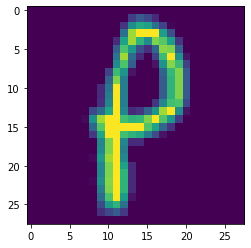

In [37]:
# testing alphabet_mapping with the dataset
n = 2
print(y_train[n])

plt.imshow(x_train[n], interpolation='nearest')
plt.show()

In [10]:
# Converting y to one-hot vectors

y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)
y_validation = to_categorical(y_validation, n_classes)

print(y_train[n])
print(y_train.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
(124800, 26)


In [13]:
def create_model():
    '''DEFINING THE CNN MODEL'''

    n_filters = 60
    size_of_filter1 = (5, 5)
    size_of_filter2 = (3, 3)
    size_of_pool = (2, 2)
    n_nodes = 500

    model = Sequential()

    model.add((Conv2D(n_filters, size_of_filter1, input_shape=(image_dimensions[0], image_dimensions[1], 1), activation='relu')))
    model.add((Conv2D(n_filters, size_of_filter1, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    
    model.add((Conv2D(n_filters//2, size_of_filter2, activation='relu')))
    model.add((Conv2D(n_filters//2, size_of_filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))

    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(n_nodes, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [14]:
# Start training the model

model = create_model()
print(model.summary())

history = model.fit(data_generator.flow(x_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_validation, y_validation),
                    shuffle=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 60)        1560      
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 60)        90060     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 60)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 30)          16230     
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 6, 30)          8130      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 30)         0         
 2D)                                                  

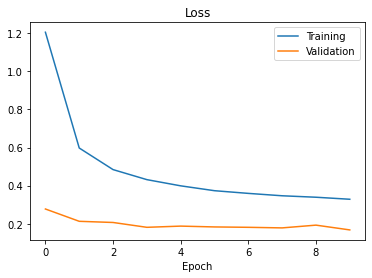

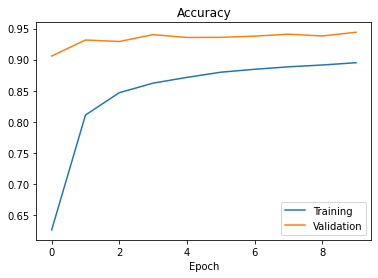

In [46]:
# print(dir(history))
# print(history.history)

# plotting the loss and accuracy of the model over the epochs
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
print(model.metrics_names)

# evaluate model
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Loss = {score[0]}')
print(f'Accuracy = {score[1]}')

# save model
model.save(saved_model_path)

# Testing out the trained model

In [16]:
from keras.models import load_model
model = load_model(saved_model_path)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}

Actual id: 10
Actual letter: K


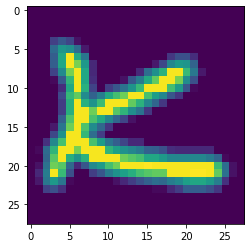

Predicted id: 10
Predicted letter: K
Accuracy: 0.9990953


In [28]:
print(alphabet_mapping)
print()

n = 7659

letter = x_train[n]
letter = cv2.resize(letter, (28, 28))
letter = letter.reshape(1, 28, 28, 1)

classId = np.argmax(y_train[n])
className = alphabet_mapping[np.argmax(y_train[n])]

print('Actual id:', classId)
print('Actual letter:', className)

plt.imshow(x_train[n], interpolation='nearest')
plt.show()

# prediction
prediction = model.predict(letter)
predictedId = np.argmax(prediction, axis=1)[0]

print('Predicted id:', predictedId)
print('Predicted letter:', alphabet_mapping[predictedId])

accuracy = np.amax(prediction)
print('Accuracy:', accuracy)